# Imports 

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB\n")

Skipping import of cpp extensions due to incompatible torch version 2.6.0+cu124 for torchao version 0.14.1             Please see https://github.com/pytorch/ao/issues/2919 for more info


Using device: cuda
GPU: NVIDIA GeForce RTX 4050 Laptop GPU
VRAM: 6.44 GB



# Model  

In [2]:
MODEL_NAME = "distilbert-base-uncased"
MAX_LENGTH = 512  # DistilBERT supports up to 512 tokens
TRUNCATION_STRATEGY = "head_tail" 

# Train/Test/Val split

Loading data...
Train columns: ['text', 'label']
Test columns: ['text', 'label']
✓ Renamed 'label' column to 'sentiment'
Train: 22500, Val: 2500, Test: 25000
Label distribution - Train: {0: 11250, 1: 11250}

Truncation Analysis:
  Reviews > 384 words: 3232 (14.4%)
  These reviews will be truncated using 'head_tail' strategy
  Median review length: 174 words
  95th percentile: 596 words

✓ Saved: data_distribution.png


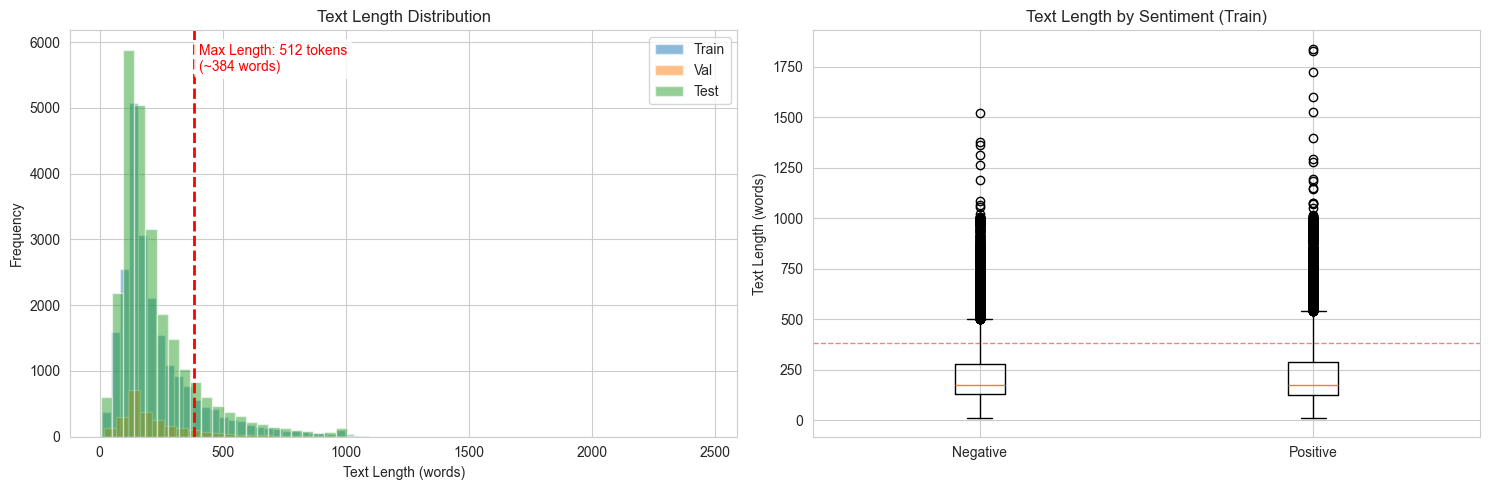

✓ Saved: text_length_analysis.png



In [6]:
print("Loading data...")
train_df = pd.read_csv(r"C:\Users\Acer\Desktop\projects\week_4\train.csv")
test_df = pd.read_csv(r"C:\Users\Acer\Desktop\projects\week_4\test.csv")

# Check column names and rename if needed
print(f"Train columns: {train_df.columns.tolist()}")
print(f"Test columns: {test_df.columns.tolist()}")

# Rename 'label' to 'sentiment' if needed for consistency
if 'label' in train_df.columns and 'sentiment' not in train_df.columns:
    train_df = train_df.rename(columns={'label': 'sentiment'})
    test_df = test_df.rename(columns={'label': 'sentiment'})
    print("✓ Renamed 'label' column to 'sentiment'")

# Verify we have required columns
if 'text' not in train_df.columns or 'sentiment' not in train_df.columns:
    raise ValueError(f"Required columns 'text' and 'sentiment' not found. Found: {train_df.columns.tolist()}")

# Create validation split (10% of training data)
train_df, val_df = train_test_split(
    train_df, test_size=0.1, random_state=42, stratify=train_df['sentiment']
)

# Calculate text lengths
train_df['text_length'] = train_df['text'].str.split().str.len()
val_df['text_length'] = val_df['text'].str.split().str.len()
test_df['text_length'] = test_df['text'].str.split().str.len()

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
print(f"Label distribution - Train: {train_df['sentiment'].value_counts().to_dict()}")

# Analyze truncation impact
max_words = int(MAX_LENGTH * 0.75)  # Rough conversion: tokens to words
long_reviews = train_df[train_df['text_length'] > max_words].shape[0]
total_reviews = len(train_df)
truncation_pct = (long_reviews / total_reviews) * 100
print(f"\nTruncation Analysis:")
print(f"  Reviews > {max_words} words: {long_reviews} ({truncation_pct:.1f}%)")
print(f"  These reviews will be truncated using '{TRUNCATION_STRATEGY}' strategy")
print(f"  Median review length: {train_df['text_length'].median():.0f} words")
print(f"  95th percentile: {train_df['text_length'].quantile(0.95):.0f} words\n")

# Visualize data distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, (name, df) in enumerate([('Train', train_df), ('Val', val_df), ('Test', test_df)]):
    counts = df['sentiment'].value_counts()
    axes[idx].bar(['Negative (0)', 'Positive (1)'], counts.values, color=['#ff6b6b', '#51cf66'])
    axes[idx].set_title(f'{name} Set Distribution')
    axes[idx].set_ylabel('Count')
    for i, v in enumerate(counts.values):
        axes[idx].text(i, v, str(v), ha='center', va='bottom')
plt.tight_layout()
plt.savefig('data_distribution.png', dpi=300, bbox_inches='tight')
print("✓ Saved: data_distribution.png")
plt.close()

# Text length analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribution plot
for name, df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    axes[0].hist(df['text_length'], bins=50, alpha=0.5, label=name)
axes[0].set_xlabel('Text Length (words)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Text Length Distribution')
axes[0].legend()
axes[0].axvline(x=max_words, color='red', linestyle='--', linewidth=2)
axes[0].text(max_words + 20, axes[0].get_ylim()[1]*0.9, 
             f'Max Length: {MAX_LENGTH} tokens\n(~{max_words} words)', 
             color='red', fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Box plot by sentiment
train_df_plot = train_df.copy()
train_df_plot['sentiment_label'] = train_df_plot['sentiment'].map({0: 'Negative', 1: 'Positive'})
data_to_plot = [train_df_plot[train_df_plot['sentiment']==0]['text_length'],
                train_df_plot[train_df_plot['sentiment']==1]['text_length']]
axes[1].boxplot(data_to_plot, labels=['Negative', 'Positive'])
axes[1].set_ylabel('Text Length (words)')
axes[1].set_title('Text Length by Sentiment (Train)')
axes[1].axhline(y=max_words, color='red', linestyle='--', linewidth=1, alpha=0.5)
plt.tight_layout()
plt.savefig('text_length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: text_length_analysis.png\n")

# Convert to HuggingFace datasets
train_dataset = Dataset.from_pandas(train_df[['text', 'sentiment']])
val_dataset = Dataset.from_pandas(val_df[['text', 'sentiment']])
test_dataset = Dataset.from_pandas(test_df[['text', 'sentiment']])

dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})


# Tokenization

In [7]:
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

# Add padding token if missing
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def preprocess_function(examples):
    """Tokenize with smart truncation strategy for long texts"""
    
    if TRUNCATION_STRATEGY == "head":
        # Standard: Keep first MAX_LENGTH tokens (beginning of review)
        return tokenizer(
            examples['text'],
            truncation=True,
            max_length=MAX_LENGTH,
            padding=False
        )
    
    elif TRUNCATION_STRATEGY == "tail":
        # Keep last MAX_LENGTH tokens (end of review)
        tokenized = tokenizer(
            examples['text'],
            truncation=False,
            padding=False
        )
        # Truncate from the beginning
        for key in tokenized.keys():
            tokenized[key] = [ids[-MAX_LENGTH:] if len(ids) > MAX_LENGTH else ids 
                             for ids in tokenized[key]]
        return tokenized
    
    elif TRUNCATION_STRATEGY == "head_tail":
        # Keep first half + last half (captures intro + conclusion)
        half_length = MAX_LENGTH // 2
        tokenized = tokenizer(
            examples['text'],
            truncation=False,
            padding=False
        )
        
        for key in tokenized.keys():
            new_ids = []
            for ids in tokenized[key]:
                if len(ids) <= MAX_LENGTH:
                    new_ids.append(ids)
                else:
                    # Concatenate first half and last half
                    combined = ids[:half_length] + ids[-half_length:]
                    new_ids.append(combined)
            tokenized[key] = new_ids
        return tokenized
    
    else:
        # Default: standard truncation
        return tokenizer(
            examples['text'],
            truncation=True,
            max_length=MAX_LENGTH,
            padding=False
        )

print(f"Tokenizing datasets with '{TRUNCATION_STRATEGY}' strategy...")
tokenized_dataset = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=['text'],
    desc="Tokenizing"
)

# Rename label column
tokenized_dataset = tokenized_dataset.rename_column("sentiment", "labels")
print("✓ Tokenization complete\n")


Loading tokenizer...
Tokenizing datasets with 'head_tail' strategy...


Tokenizing:   0%|          | 0/22500 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (599 > 512). Running this sequence through the model will result in indexing errors


Tokenizing:   0%|          | 0/2500 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/25000 [00:00<?, ? examples/s]

✓ Tokenization complete



In [8]:
print("Loading model...")

# For DistilBERT and Longformer (no quantization needed)
if "distilbert" in MODEL_NAME.lower() or "longformer" in MODEL_NAME.lower():
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=2,
        id2label={0: "negative", 1: "positive"},
        label2id={"negative": 0, "positive": 1}
    )
else:
    # For larger models (TinyLlama, Phi-2) - use 4-bit quantization
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True
    )
    
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=2,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True,
        id2label={0: "negative", 1: "positive"},
        label2id={"negative": 0, "positive": 1}
    )

model.to(device)
print("✓ Model loaded\n")

Loading model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded



In [6]:
print(device)

cuda


# Prompt Engineering 
Trying 0-shot,1-shot and 3-shot prompts to find out which type of prompts produces best llm response.

In [15]:
# 0-shot: no examples, just instructions
zero_shot_templates = [
    "Determine if the following movie review is Positive or Negative:\n\n'{text}'\nAnswer:"
]

# 1-shot: one example included
one_shot_templates = [
    "Example:\n"
    "Review: 'I went into this movie with pretty low expectations, but I was genuinely surprised by how engaging it turned out to be. "
    "The performances felt natural, the pacing was tight, and the emotional moments actually landed without feeling forced. "
    "Even though a few scenes dragged a little, the overall experience was warm and memorable.' → Positive\n\n"
    "Now classify this review:\n'{text}'\nAnswer:"
]

# 3-shot: three examples included
three_shot_templates = [
    "Examples:\n"
    "Review 1: 'The movie started off promising but quickly lost its charm. The middle portion dragged endlessly, "
    "and the subplots felt unnecessary. Despite a strong lead performance, the overall execution left me disappointed.' → Negative\n\n"
    "Review 2: 'I was surprised by how emotionally resonant this film turned out to be. The storytelling is subtle but powerful, "
    "and the cinematography elevates every important moment. It's the kind of movie that stays with you long after you leave the theater.' → Positive\n\n"
    "Review 3: 'Not every scene hits perfectly, but the movie has a certain warmth that kept me invested throughout. "
    "The characters feel genuine, and the humor is sprinkled in naturally. It’s far from perfect, but overall, it’s an enjoyable watch.' → Positive\n\n"
    "Now classify this review:\n'{text}'\nAnswer:"
]


In [16]:
import torch
import torch.nn.functional as F

MAX_LENGTH = 512  # adjust for your model

def predict_review_prompt(review_text, prompt_template):
    prompt = prompt_template.format(text=review_text)
    
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=MAX_LENGTH
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=-1)
        pred_class = torch.argmax(probs, dim=1).item()  # 0 or 1

    confidence = probs[0][pred_class].item()
    return pred_class, confidence  # integer




In [17]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

prompt_styles = {
    "0-shot": zero_shot_templates,
    "1-shot": one_shot_templates,
    "3-shot": three_shot_templates
}

results = []

val_subset = val_df  # or val_df.head(2000) if you want a smaller subset

for style_name, templates in prompt_styles.items():
    print(f"\nEvaluating {style_name} prompting...")
    
    all_preds = []
    all_labels = []
    
    for i, row in tqdm(val_subset.iterrows(), total=len(val_subset)):
        review_text = row["text"]
        true_label = row["sentiment"]
        
        template = templates[i % len(templates)]  # rotate templates if multiple
        pred_label, _ = predict_review_prompt(review_text, template)
        
        all_preds.append(pred_label)
        all_labels.append(true_label)
    
    # Metrics
    acc = accuracy_score(all_labels, all_preds)
    f1_bin = f1_score(all_labels, all_preds, pos_label=1)
    f1_macro = f1_score(all_labels, all_preds, average="macro")
    prec_macro = precision_score(all_labels, all_preds, average="macro")
    rec_macro = recall_score(all_labels, all_preds, average="macro")
    
    results.append({
        "style": style_name,
        "accuracy": acc,
        "f1_binary": f1_bin,
        "f1_macro": f1_macro,
        "precision_macro": prec_macro,
        "recall_macro": rec_macro
    })

# Convert to DataFrame for easy comparison
import pandas as pd
metrics_df = pd.DataFrame(results)
print(metrics_df)



Evaluating 0-shot prompting...


100%|██████████| 2500/2500 [00:20<00:00, 123.39it/s]



Evaluating 1-shot prompting...


100%|██████████| 2500/2500 [00:23<00:00, 108.04it/s]



Evaluating 3-shot prompting...


100%|██████████| 2500/2500 [00:27<00:00, 91.05it/s]

    style  accuracy  f1_binary  f1_macro  precision_macro  recall_macro
0  0-shot    0.4976   0.663991  0.334373         0.374397        0.4976
1  1-shot    0.4996   0.666133  0.333865         0.416567        0.4996
2  3-shot    0.5000   0.666489  0.334043         0.500000        0.5000


In [22]:
import torch
import torch.nn.functional as F
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

# Correct path: go up one folder
MODEL_PATH = "../imdb_lora_model"

print("Loading tokenizer & model...")
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_PATH)
model = DistilBertForSequenceClassification.from_pretrained(MODEL_PATH)
model.to(device)
model.eval()

MAX_LENGTH = 512
print("Model loaded successfully.")


Loading tokenizer & model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully.


In [23]:
# 0-shot: no examples, just instructions
zero_shot_templates = [
    "Determine if the following movie review is Positive or Negative:\n\n'{text}'\nAnswer:"
]

# 1-shot: one example included
one_shot_templates = [
    "Example:\n"
    "Review: 'I went into this movie with pretty low expectations, but I was genuinely surprised by how engaging it turned out to be. "
    "The performances felt natural, the pacing was tight, and the emotional moments actually landed without feeling forced. "
    "Even though a few scenes dragged a little, the overall experience was warm and memorable.' → Positive\n\n"
    "Now classify this review:\n'{text}'\nAnswer:"
]

# 3-shot: three examples included
three_shot_templates = [
    "Examples:\n"
    "Review 1: 'The movie started off promising but quickly lost its charm. The middle portion dragged endlessly, "
    "and the subplots felt unnecessary. Despite a strong lead performance, the overall execution left me disappointed.' → Negative\n\n"
    "Review 2: 'I was surprised by how emotionally resonant this film turned out to be. The storytelling is subtle but powerful, "
    "and the cinematography elevates every important moment. It's the kind of movie that stays with you long after you leave the theater.' → Positive\n\n"
    "Review 3: 'Not every scene hits perfectly, but the movie has a certain warmth that kept me invested throughout. "
    "The characters feel genuine, and the humor is sprinkled in naturally. It’s far from perfect, but overall, it’s an enjoyable watch.' → Positive\n\n"
    "Now classify this review:\n'{text}'\nAnswer:"
]


In [24]:
def predict_review_prompt(review_text, prompt_template):
    prompt = prompt_template.format(text=review_text)
    
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=MAX_LENGTH
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=-1)
        pred_class = torch.argmax(probs, dim=1).item()  # 0 or 1

    confidence = probs[0][pred_class].item()
    return pred_class, confidence  # return integer


In [25]:
prompt_styles = {
    "0-shot": zero_shot_templates,
    "1-shot": one_shot_templates,
    "3-shot": three_shot_templates
}

results = []

val_subset = val_df  # full validation set or subset if you want

for style_name, templates in prompt_styles.items():
    print(f"\nEvaluating {style_name} prompting...")
    
    all_preds = []
    all_labels = []
    
    for i, row in tqdm(val_subset.iterrows(), total=len(val_subset)):
        review_text = row["text"]
        true_label = int(row["sentiment"])  # ensure integer
        
        template = templates[i % len(templates)]
        pred_label, _ = predict_review_prompt(review_text, template)
        
        all_preds.append(pred_label)
        all_labels.append(true_label)
    
    # Metrics
    acc = accuracy_score(all_labels, all_preds)
    f1_bin = f1_score(all_labels, all_preds)  # pos_label=1 by default
    f1_macro = f1_score(all_labels, all_preds, average="macro")
    prec_macro = precision_score(all_labels, all_preds, average="macro")
    rec_macro = recall_score(all_labels, all_preds, average="macro")
    
    results.append({
        "style": style_name,
        "accuracy": acc,
        "f1_binary": f1_bin,
        "f1_macro": f1_macro,
        "precision_macro": prec_macro,
        "recall_macro": rec_macro
    })

# Convert to DataFrame for easy comparison
metrics_df = pd.DataFrame(results)
print("\nValidation Metrics for Fine-tuned Model:")
print(metrics_df)



Evaluating 0-shot prompting...


100%|██████████| 2500/2500 [00:21<00:00, 115.21it/s]



Evaluating 1-shot prompting...


100%|██████████| 2500/2500 [00:23<00:00, 107.28it/s]



Evaluating 3-shot prompting...


100%|██████████| 2500/2500 [00:27<00:00, 90.31it/s]


Validation Metrics for Fine-tuned Model:
    style  accuracy  f1_binary  f1_macro  precision_macro  recall_macro
0  0-shot    0.9180   0.917638  0.917998         0.918032        0.9180
1  1-shot    0.7660   0.808008  0.754234         0.829002        0.7660
2  3-shot    0.7164   0.778230  0.692498         0.814041        0.7164
